# Tree tomography - December 17, 2023

This covers the first day's data taken from a cedar log (aka "The Log o' Science").

In [1]:
from datetime import datetime, timedelta
import json
import math
import pytz

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
# import scipy
import scipy.stats as st
# pd.set_option('max_columns', 50)

mpl.style.use('ggplot')

%matplotlib inline

# Today's data

- no holes: the log in its original condition.
- one hole: the log with one 1" (2.54 cm) hole drilled out in the middle.
- three holes: the log with that 1" hole extended on either side; total length ~ 2.75", total depth ~ 3.5"
- three holes, second time: after moving the protective board for sensor 1 so now poking up above log level -- hopefuly to get more consistent hit from hammer
  - With three holes, the new travel distance between sensors should have been roughly 10% longer (at minimum...there may be multiple paths we're picking up here.)
- Files edited to remove outliers (values in 10s or 100s of thousands of microseconds)

TODO: Add pictures


In [2]:
df = pd.DataFrame()
# Note: there are more values for the three_holes file.  We'll read this in first 
# so we don't have everything clamped to the shorter length of the no_holes file,
# but then we'll swap things around.
df["three_holes"] = pd.read_csv("third_run_1_to_2.csv", header=None)
df["one_hole"] = pd.read_csv("second_run_1_to_2.csv", header=None)
df["no_holes"] = pd.read_csv("first_run_1_to_2.csv", header=None)

cols = list(df.columns)
cols.reverse()
df = df[cols]
df["three_holes_second_time"] = pd.read_csv("2023-12-17_15:40:39.csv", header=None)

NOTE: I'm going to combine the two "three_holes" columns into one called "three_holes_MERGED".  The `three_holes_second_time` column definitely shows more consistent measurements, but I want to compare the two runs separately & combined.

In [3]:
s = pd.concat([df["three_holes"], df["three_holes_second_time"].dropna()], ignore_index=True)

df = pd.concat([df, s], axis=1)
df = df.rename(columns={0: "three_holes_MERGE"})
df

,no_holes,one_hole,three_holes,three_holes_second_time,three_holes_MERGE
0,421.18,701.76,697.00,751.28,697.00
1,698.22,714.18,464.00,723.32,464.00
2,694.68,695.54,1609.88,737.48,1609.88
3,725.82,728.60,482.98,732.56,482.98
4,1356.54,709.28,706.30,711.70,706.30
...,...,...,...,...,...
73,NaN,NaN,NaN,NaN,753.28
74,NaN,NaN,NaN,NaN,748.82
75,NaN,NaN,NaN,NaN,737.48
76,NaN,NaN,NaN,NaN,742.82


Let's start with some plots!

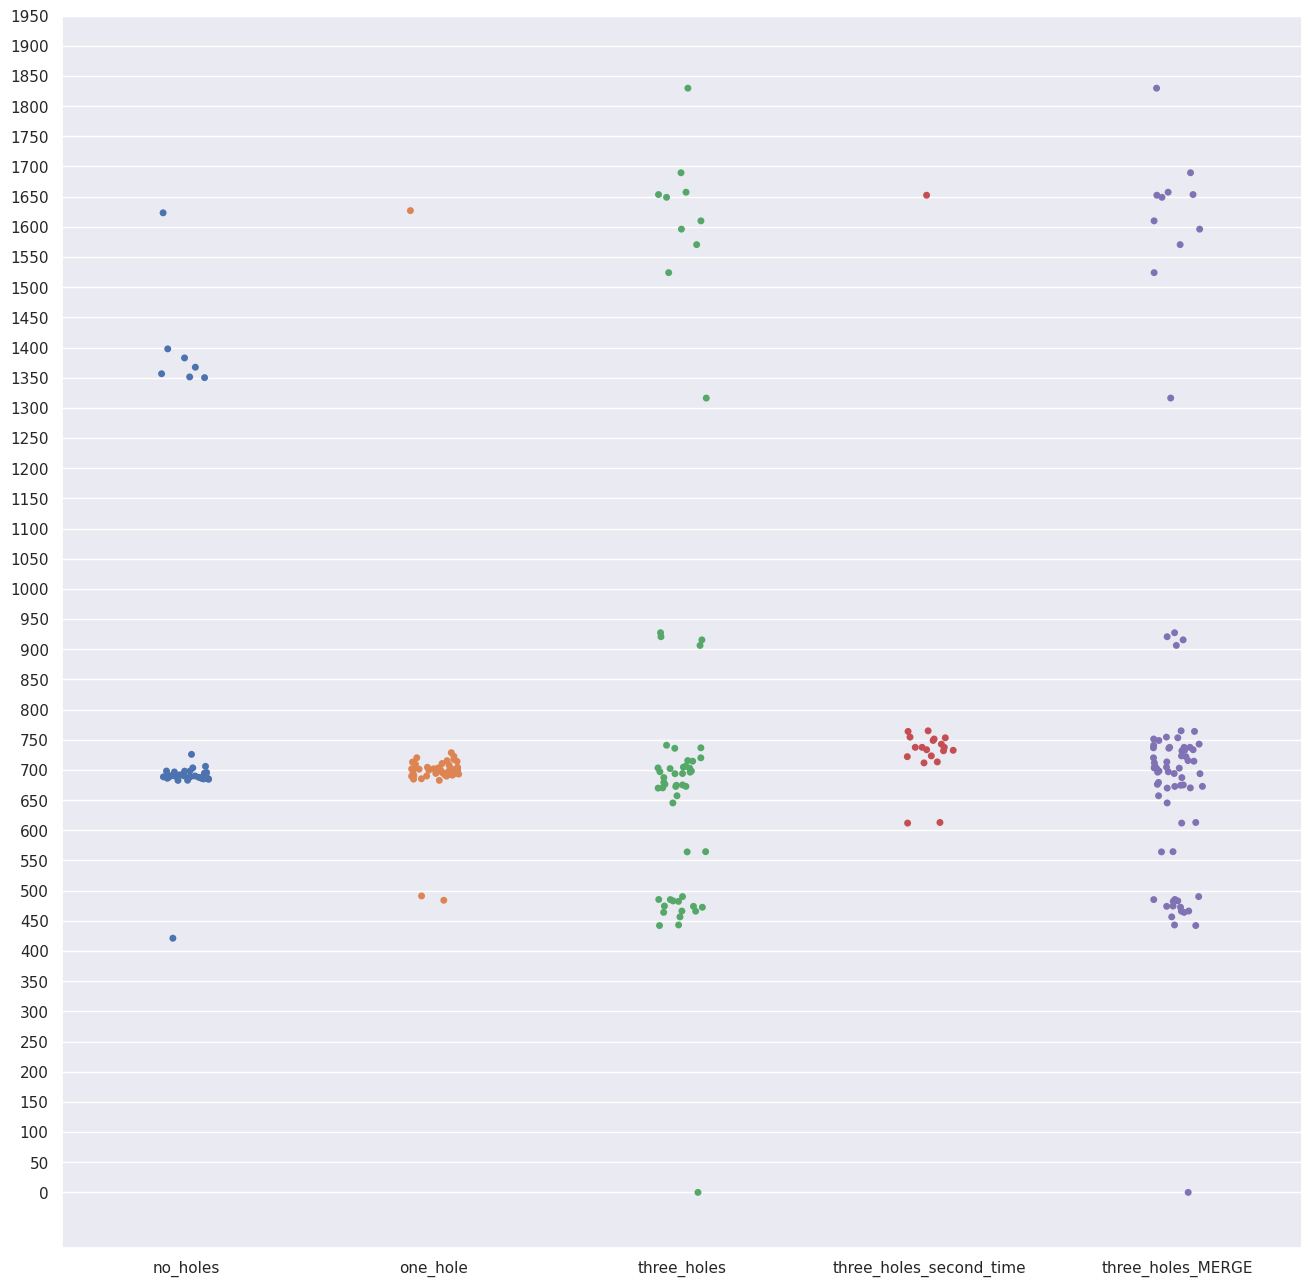

In [4]:
sns.set(rc={"figure.figsize":(16, 16)}) #width=8, height=4

line_plot = sns.stripplot(data=df) # .set(title="Sensor 1 -> 2 in Log o' Science", ylabel="microseconds")
plt.yticks([y for y in range(0, 2000, 50)])
fig = line_plot.get_figure()
fig.savefig('my_lineplot.png')

# First impressions
* The spread in the three hole data is quite obvious.
* It's interesting to see the data between 400 & 500 microseconds:
  * one value for no holes, one hole
  * a dozen or more for three holes
* Same is true for 1500-1800 microseconds, though that ignores the 1350-1400 microsecond cluster in no hole data.
* Need more data!
  * There was a certain amount of moving/changing things.
  * The hammer was resting on the board; it should be stood up beside it.
  * Wonder if the single value clusters in no holes/one holes would have been multiple values if I'd got, say, 100 hits each.
* I *really* wonder what's going on with the clustering.

# Looking at the cluster at 600-800 microseconds

Let's take a look at mean, std deviation, and confidence intervals. NOTE: I'm deliberately limiting the range of values to the 600-800 microsecond cluster.

In [5]:
def get_mean_and_std_in_cluster(df: pd.DataFrame, col: str, min: float, max: float) -> (float, float):
    """Get the mean of a column in df where its 
    values are between min and max.

    Helpful for getting the mean of a cluster, 
    rather than the mean of the whole column.

    Args:
      df: dataframe
      col: name of column in dataframe
      min: min range
      max: max range

    Returns:
      tuple(float, float): mean and stddev of values in that range
    """
    idx = df[col].between(min, max, inclusive="both")
    # print(idx)
    return (
        df[col][idx].mean(),
        df[col][idx].std(),
    )

for col in df.columns:
    print(f"{col}: ", end="")
    print(get_mean_and_std_in_cluster(df, col, 600, 800))

no_holes: (692.018125, 8.330817036761761)
one_hole: (700.6917073170731, 10.658549597022812)
three_holes: (694.1962962962963, 23.984223043195602)
three_holes_second_time: (725.517894736842, 42.5776659736778)
three_holes_MERGE: (707.1334782608695, 36.064297902335575)


In [6]:
def get_confidence_interval(df, col, min=600.0, max=800.0):
    """Get confidence interval for col in df.

    This uses scipy's confidence interval function, which does
    not appear to take into account sample size.
    """
    mean, std = get_mean_and_std_in_cluster(df, col, min, max)
    crange_extremes = st.norm.interval(0.95, loc=mean, scale=std)
    crange = (crange_extremes[1] - crange_extremes[0]) / 2
    print(f"{mean} +/- {crange/2}")


get_confidence_interval(df, "no_holes")

692.018125 +/- 8.164050676922898


Note: that confidence interval does not line up with this tool: https://www.omnicalculator.com/statistics/confidence-interval

That one takes into account population size.  I'm going to implement that function here.

(Further ref:: https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Foundations_in_Statistical_Reasoning_(Kaslik)/06%3A_Confidence_Intervals_and_Sample_Size)

In [7]:
P95_ZSCORE = 1.959964

def another_confidence_interval(df, col, min=600.0, max=800.0, zscore=P95_ZSCORE):
    """Get confidence interval, following example at 
    https://www.omnicalculator.com/statistics/confidence-interval
    """
    mean, std = get_mean_and_std_in_cluster(df, col, min, max)
    # z * (s / n^0.5)
    n = len(df[col].dropna())
    ci = zscore * (std / math.sqrt(n))
    print(f"{mean:.2f} +/- {ci:.2f} ({n=}, {std=}")


for col in df.columns:
    print(f"{col}: ", end="") 
    another_confidence_interval(df, col)
    print()

no_holes: 692.02 +/- 2.58 (n=40, std=8.330817036761761

one_hole: 700.69 +/- 3.15 (n=44, std=10.658549597022812

three_holes: 694.20 +/- 6.17 (n=58, std=23.984223043195602

three_holes_second_time: 725.52 +/- 18.66 (n=20, std=42.5776659736778

three_holes_MERGE: 707.13 +/- 8.00 (n=78, std=36.064297902335575



Interesting; I think we see a higher measurement for three holes, but we definitely need more data. 

# A couple more plots

Let's look at boxplots & violin plots.

<Axes: >

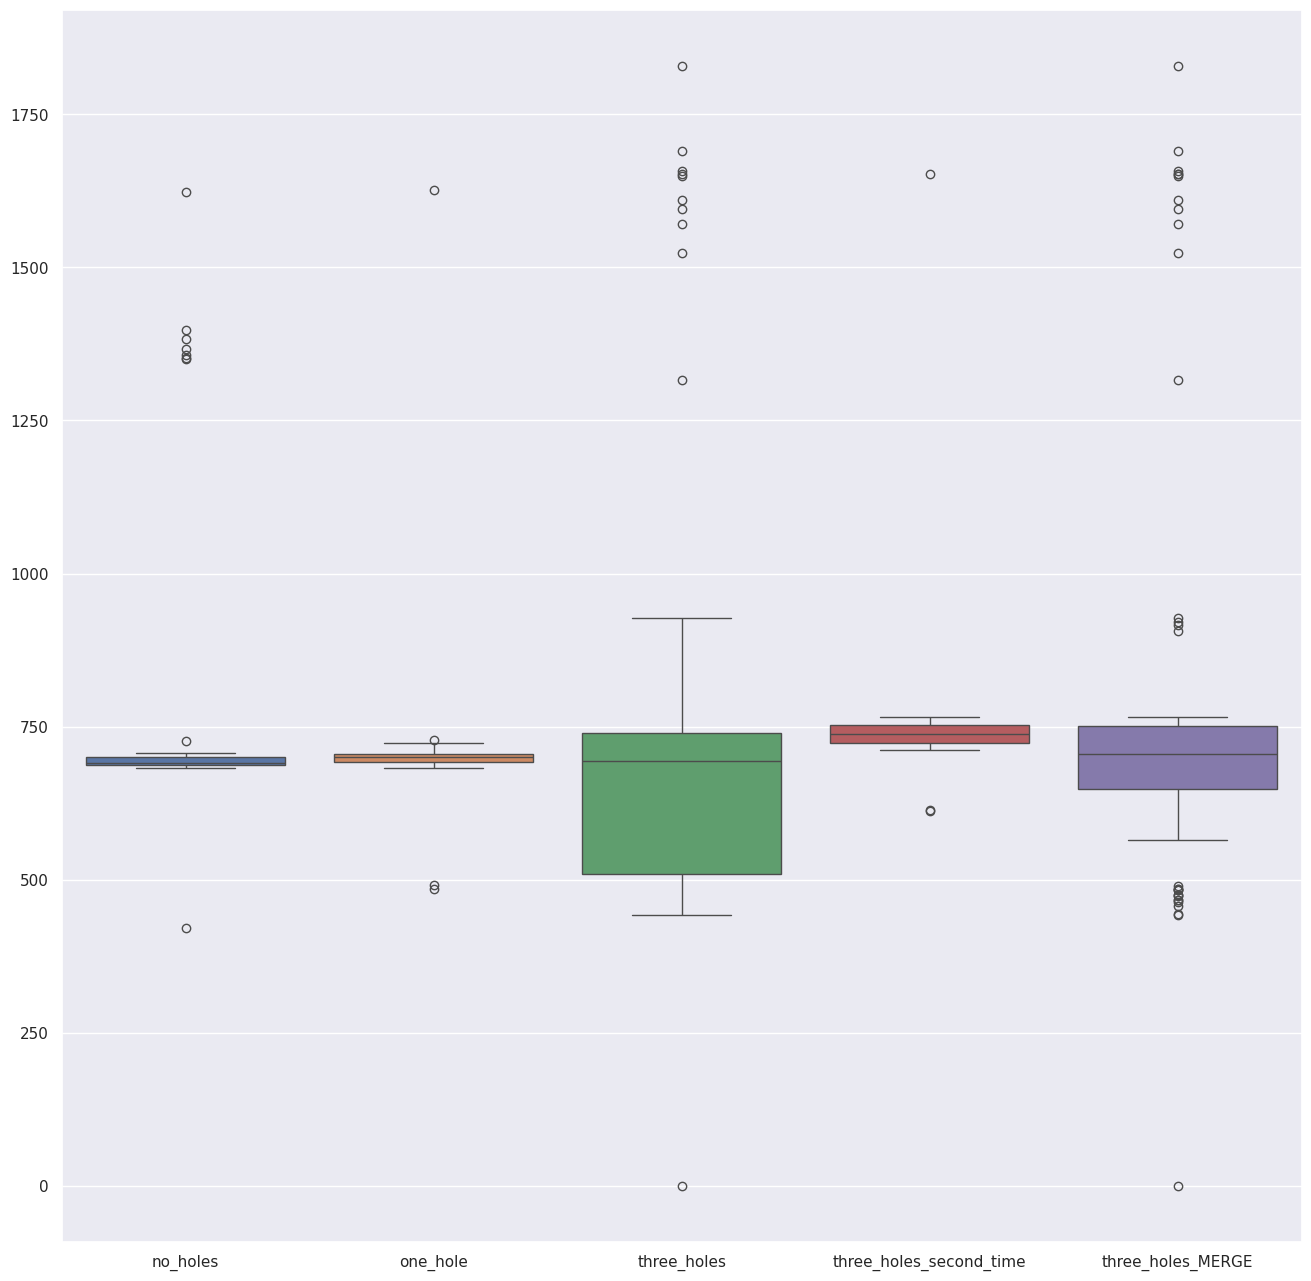

In [8]:
sns.boxplot(df)

<Axes: >

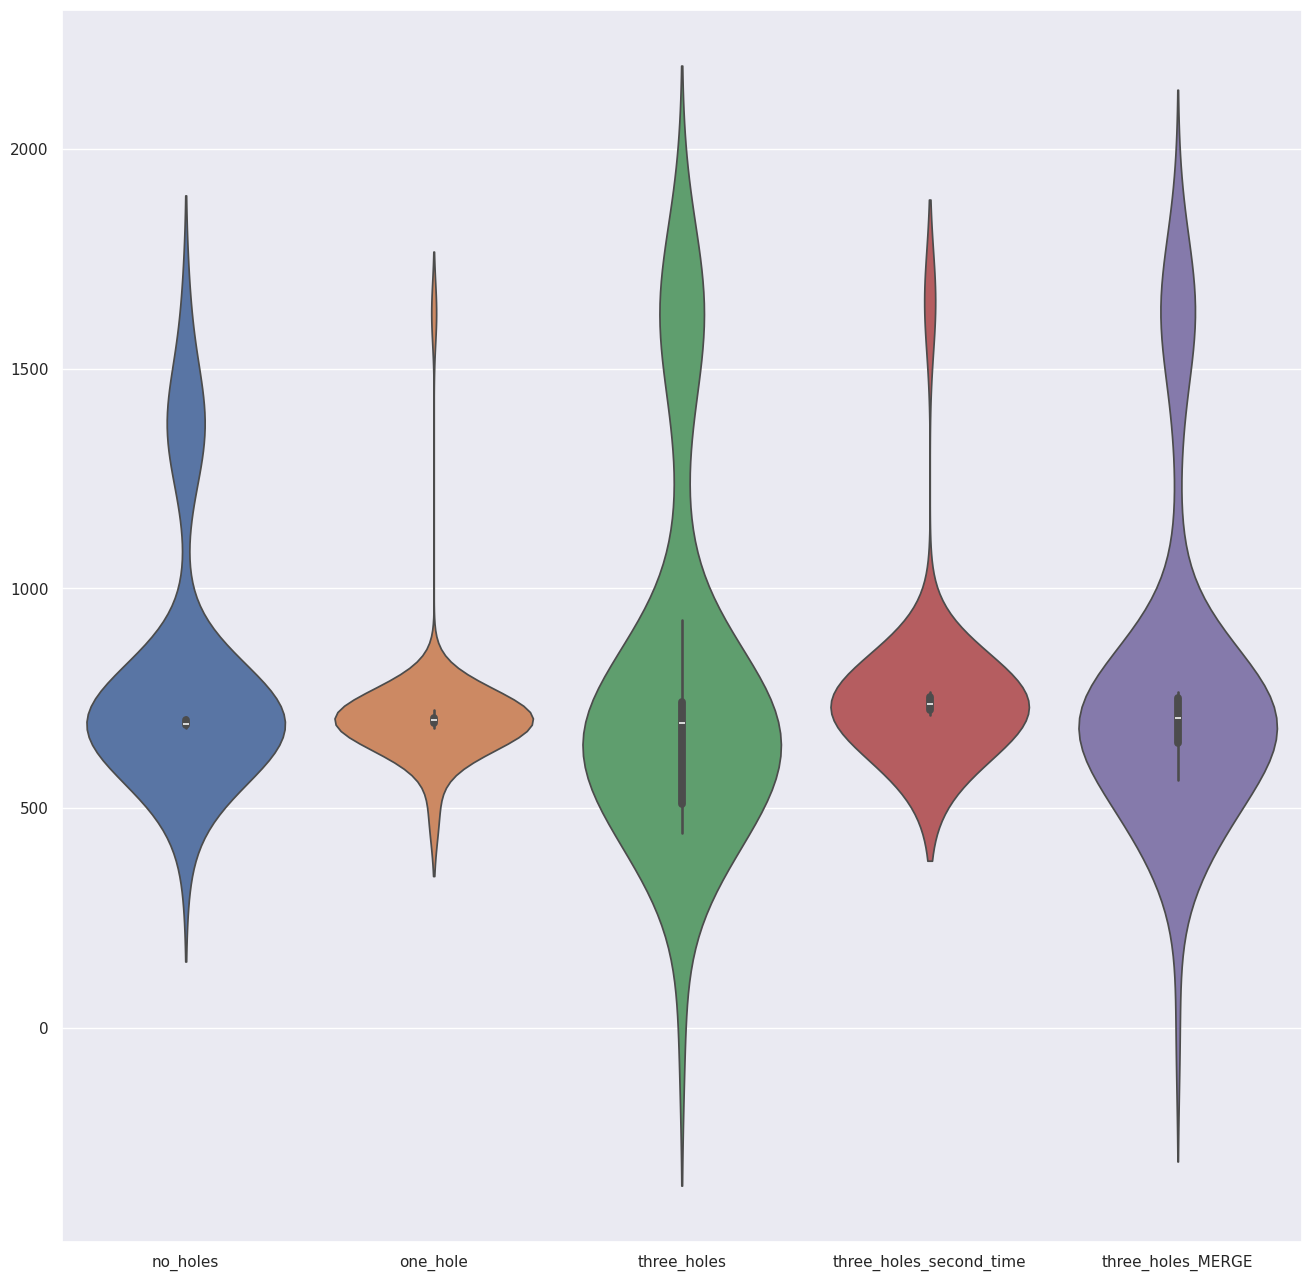

In [9]:
sns.violinplot(df)

Suggestion from a coworker: how is the three hole data distributed through time?  Is there something about the testing rig that might change over time?  Do all the large values come toward the beginning or end of the run?

<Axes: ylabel='three_holes'>

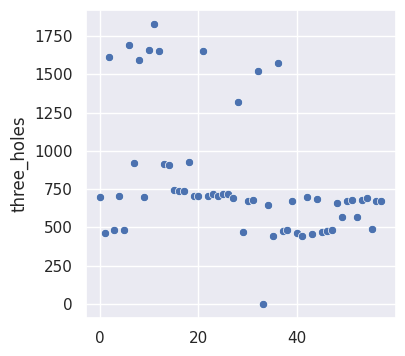

In [10]:
sns.set(rc={"figure.figsize":(4, 4)})
sns.scatterplot(data=df["three_holes"])

Hm -- sure is something about the 40th-50th sample that make it look like it quieted down.

# Experimenting with clustering

It was also suggested that I could try clustering the data with kmeans, so let's see if I can give that a try.

In [11]:
from scipy.cluster.vq import kmeans, whiten

def kmeans_onecol(df: pd.DataFrame, col: str):
    """Do kmeans on just one column"""
    vals = df[df[col].isnull() == False][col]
    whitened = whiten(vals)
    codebook, distortion = kmeans(whitened, 2)
    print(codebook)
    plt.scatter(whitened, whitened)
    plt.scatter(codebook, codebook, c='r')
    plt.show()

[ 4.70759038 11.08669242]


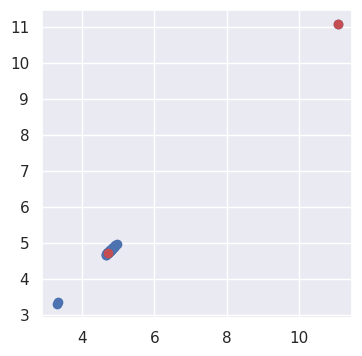

In [12]:
kmeans_onecol(df, "one_hole")

[1.81102203 4.45839465]


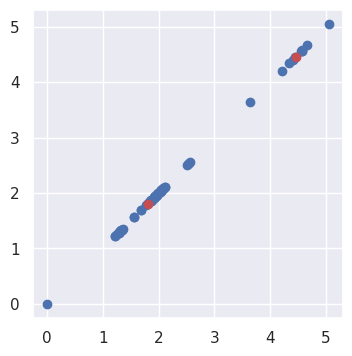

In [13]:
kmeans_onecol(df, "three_holes_MERGE")

In [14]:
df.columns

Index(['no_holes', 'one_hole', 'three_holes', 'three_holes_second_time',
       'three_holes_MERGE'],
      dtype='object')

Hm.  A couple things:

- this is worth investigating as a way to group plots.
- picked scipy method randomly.  how does this compare w/sklearn?
- how do I plot bounding box around group?
- not sure I understand at all how to do 2d kmeans clustering with my data.

# Is this data normally distributed?

I'd like to figure out if the data is normally distributed.  Let's plot some histograms.

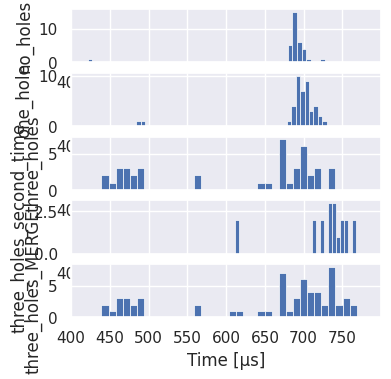

In [15]:
# plot:
fig, ax = plt.subplots(5, 1)
fig.suptitle = "No holes"

lower, upper = 400, 800

# TODO: What's that python trick where you
i = 0
for col in list(df.columns):
    ax[i].hist(df[col], bins=200, linewidth=0.5, edgecolor="white")
    ax[i].set(xlim=(lower, upper), xticks=np.arange(lower, upper, 50))
    ax[i].set_xlabel('Time [μs]')
    ax[i].set_ylabel(col)
    i += 1

plt.show()

Interesting -- no hole & one hole looks pretty close to normal distribution. Three holes (both) do not.  

More data more better, but maybe one hypothesis is:

- with no holes, we're taking a direct path; thus, normal, since we're taking measurements of one thing.
  - one hole: maybe we have *mostly* one path?  Like, it's not enough to seriously deflect things?
- with three holes, now we have a serious obstacle; thus, we have multiple paths through, and there are lots of things we're measuring.

What about the data from 1400 to 1800?

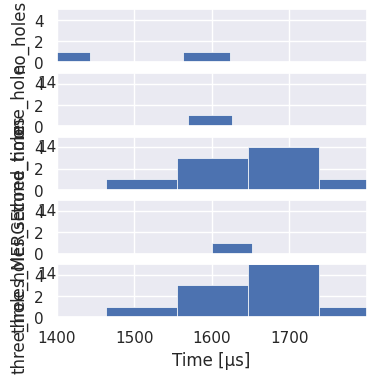

In [16]:
# plot:
fig, ax = plt.subplots(5, 1)
fig.suptitle = "No holes"

lower, upper = 1400, 1800

# TODO: What's that python trick where you
i = 0
for col in list(df.columns):
    ax[i].hist(df[col], bins=20, linewidth=0.5, edgecolor="white")
    ax[i].set(xlim=(lower, upper), ylim=(0, 5), xticks=np.arange(lower, upper, 100), yticks=np.arange(0, 5, 2))    
    ax[i].set_xlabel('Time [μs]')
    ax[i].set_ylabel(col)
    i += 1

plt.show()

Not enough data to tell.

# Conclusions

- Starting to get a better handle on basic statistics
- Definitely interesting differences
- NEED MOAR DATA